In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import tree
import graphviz


In [2]:
train_data = 'C:/YunTech/dataset/adult/adult.data'
test_data = 'C:/YunTech/dataset/adult/adult.test'
columns=['age', 'workclass', 'fnlgwt', 'education', 'educationnum', 'marital-status', 'occupation', 'relationship', 
         'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'country', 'income']
df_train_set = pd.read_csv(train_data, names = columns)
df_test_set = pd.read_csv(test_data, names = columns, skiprows = 1)

In [3]:
# Preprocessing

# fnlgwt is ID number.
df_train_set.drop('fnlgwt', axis = 1, inplace =True)
df_test_set.drop('fnlgwt', axis = 1, inplace =True)

for i in df_train_set.columns:
    df_train_set[i].replace('?', 'unknown', inplace = True)
    df_test_set[i].replace('?', 'unknown', inplace = True)

    # 刪掉非'int64'數據型態的點or空格，提高精度
    for col in df_train_set.columns:
        if df_train_set[col].dtype != 'int64':
            df_train_set[col] = df_train_set[col].apply(lambda val: val.replace(" ", ""))
            df_train_set[col] = df_train_set[col].apply(lambda val: val.replace(".", ""))
            df_test_set[col] = df_test_set[col].apply(lambda val: val.replace(" ", ""))
            df_test_set[col] = df_test_set[col].apply(lambda val: val.replace(".", ""))

# 特徵相似，減少干擾因素，drop
df_train_set.drop(["country", "education"], axis=1, inplace=True)
df_test_set.drop(["country", "education"], axis=1, inplace=True)

col_name = list(df_train_set.columns)
col_name.remove('age')
col_name.remove('educationnum')
col_name = ['AgeGroup', 'EduGroup']+col_name

labels = ["{0}-{1}  ".format(i, i+9) for i in range(0, 100, 10)]
df_train_set['AgeGroup'] = pd.cut(df_train_set.age, range(0, 101, 10), right=False, labels=labels)
df_test_set['AgeGroup'] = pd.cut(df_test_set.age, range(0, 101, 10), right=False, labels=labels)

labels = ["{0}-{1}".format(i, i+4) for i in range(0, 20, 5)]
df_train_set['EduGroup'] = pd.cut(df_train_set.educationnum, range(0, 21, 5), right=False, labels=labels)
df_test_set['EduGroup'] = pd.cut(df_test_set.educationnum, range(0, 21, 5), right=False, labels=labels)

df_train_set = df_train_set[col_name]
df_test_set = df_test_set[col_name]


In [4]:
df_test_set.apply(lambda x : np.sum(x == " ?"))

AgeGroup          0
EduGroup          0
workclass         0
marital-status    0
occupation        0
relationship      0
race              0
gender            0
capital-gain      0
capital-loss      0
hours-per-week    0
income            0
dtype: int64

In [5]:
mapper = DataFrameMapper([('AgeGroup', LabelEncoder()),('EduGroup', LabelEncoder()),
                          ('workclass', LabelEncoder()),('marital-status', LabelEncoder()),
                          ('occupation', LabelEncoder()),('relationship',LabelEncoder()),
                          ('race',LabelEncoder()),('gender',LabelEncoder()),
                          ('income', LabelEncoder())], df_out=True, default=None)

cols = list(df_train_set.columns)
cols.remove('income')
cols = cols[:-3]+['income']+cols[-3:]

df_train = mapper.fit_transform(df_train_set.copy())
df_train.columns = cols
df_test = mapper.transform(df_test_set.copy())
df_test.columns = cols 
cols.remove('income')

In [6]:
# 訓練數據與測試數據劃分
x_train, y_train = df_train[cols].values, df_train['income'].values
x_test, y_test = df_test[cols].values, df_test['income'].values

In [7]:
# 模型初步訓練與評分
treeClassifier = DecisionTreeClassifier()
treeClassifier.fit(x_train, y_train)
score = treeClassifier.score(x_test, y_test)
print('Accuracy: ', score)

Accuracy:  0.835820895522388


In [9]:
from sklearn.model_selection import GridSearchCV
paras = {
    'max_features': (None, 9, 6),
    'max_depth':(None, 24, 16),
    'min_samples_split':(2, 4, 8),
    'min_samples_leaf':(16, 4, 12)
}

clf = GridSearchCV(treeClassifier, paras, cv = 5)
clf.fit(x_train, y_train)
clf.best_score_, clf.score(x_test, y_test), clf.best_params_
print('After GridSearch Best Score: ', clf.best_score_)
print('After GridSearch Score: ', clf.score(x_test, y_test))
print('Best Parameter: ', clf.best_params_)

After GridSearch Best Score:  0.858757574625838
After GridSearch Score:  0.8576868742706222
Best Parameter:  {'max_depth': 16, 'max_features': 9, 'min_samples_leaf': 12, 'min_samples_split': 8}


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_test, y_pred, random_state=0)

clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

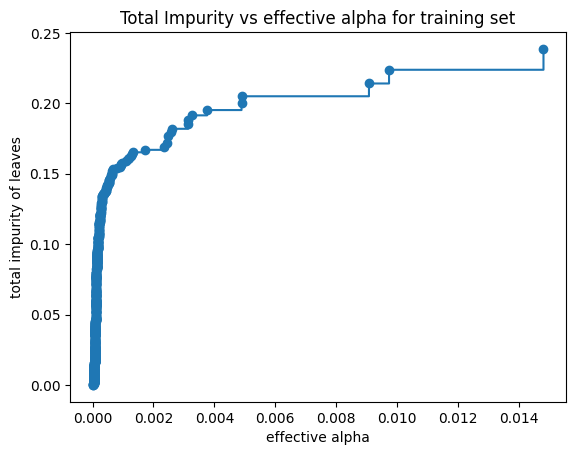

In [ ]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.09602422044126335


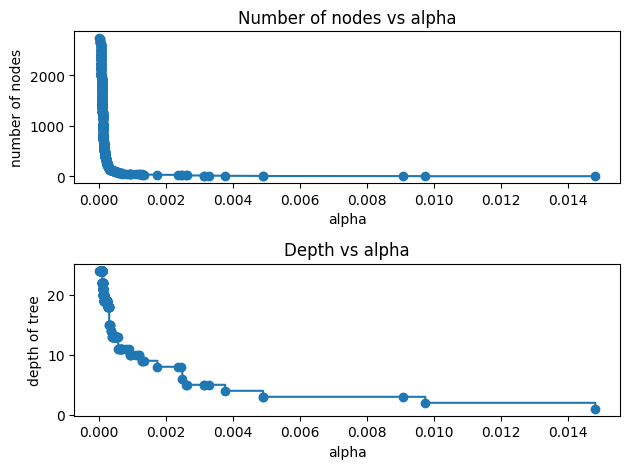

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()